In [1]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


# 3D_Dilated CNN
- Clahe
- Data Aug_abnormal case_Over Sampling

In [4]:
# Download packages
!pip install pydicom
!pip install imgaug
!pip install cv2
!pip install tensorflow
!pip install keras 

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached scipy-1.4.1-cp38-cp38-manylinux1_x86_64.whl (26.0 MB)


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Processing /home/niausr/.cache/pip/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c/PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl


In [21]:
# Load Libraries
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [23]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [24]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('./metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [88]:
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
#
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal ,Y_tr_abnormal = [], [], [], [] 
    for tr_idx in tr_list:
        X_i_tr_ct_list = sorted(glob.glob(path+patient_meta[tr_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            # 전처리 --> normalize --> resize   
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
        ct_block = np.array(ct_block)
         # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[tr_idx, 0],'DX']
        dx_block = np.array(dx_block)
    
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1   # for 문 마지막 인덱스 설정
        X_i_tr_buffer = []
        X_i_tr_abnormal_buffer = []
        # 환자의 진단명에 따라 다르게 저장해준다.
        # 0 이면 일반 리스트
        # 0 이아니면 abnormal 리스트 
        
        retNum = 0;
        for z in range(n_window):
            maxVal = np.max(dx_block[z:z+window_size])
            if (maxVal != 0 ):
                X_i_tr_abnormal_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
                X_p_tr_abnormal.append(patient_meta[tr_idx, 0])            # 환자 번호
                X_m_tr_abnormal.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보
                Y_tr_abnormal.append(maxVal)                               # DX
            else :
                if (retNum % 10 == 0):
                    X_i_tr_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
                    X_p_tr.append(patient_meta[tr_idx, 0])            # 환자 번호
                    X_m_tr.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보 
                    Y_tr.append(maxVal)                               # DX
            
            retNum += 1;
            
            
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        X_i_tr_abnormal_buffer = np.array(X_i_tr_abnormal_buffer)
        X_i_tr_abnormal.extend(X_i_tr_abnormal_buffer)
        
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal, Y_tr_abnormal = np.array(X_p_tr_abnormal), np.array(X_m_tr_abnormal), np.array(X_i_tr_abnormal), np.array(Y_tr_abnormal)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)
    
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        X_i_te_ct_list = sorted(glob.glob(path+patient_meta[te_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
                ct_block.append(cv2.resize(cv2.normalize((pdc.dcmread(X_i_te_ct_list[z])).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dsize=size))
        ct_block = np.array(ct_block)
        
        # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[te_idx, 0],'DX']
        dx_block = np.array(dx_block)
  
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_meta[te_idx, 0])
            X_m_te.append(patient_meta[te_idx, 2:])

            maxVal = np.max(dx_block[z:z+window_size])
            Y_te.append(maxVal)                               # DX
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    break

(919,) (919, 3) (919, 5, 64, 64) (919,)
(2052,) (2052, 3) (2052, 5, 64, 64) (2052,)
(2460,) (2460, 3) (2460, 5, 64, 64) (2460,)


In [89]:
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(2052,) (2052, 3) (2052, 5, 64, 64) (2052,)


In [90]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [91]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr_abnormal[Y_tr_abnormal==1]), len(Y_tr_abnormal[Y_tr_abnormal==2]), len(Y_tr_abnormal[Y_tr_abnormal==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

919 1123 631 298
1908 248 174 130


In [92]:
# Save Dataset

#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
np.save(path+'X_p_tr_final2', X_p_tr), np.save(path+'X_m_tr_final2', X_m_tr), np.save(path+'X_i_tr_final2', X_i_tr), np.save(path+'Y_tr_final2', Y_tr)
np.save(path+'X_p_te_final2', X_p_te), np.save(path+'X_m_te_final2', X_m_te), np.save(path+'X_i_te_final2', X_i_te), np.save(path+'Y_te_final2', Y_te)
np.save(path+'X_p_tr_abnormal_final2', X_p_tr_abnormal), np.save(path+'X_m_tr_abnormal_final2', X_m_tr_abnormal), np.save(path+'X_i_tr_abnormal_final2', X_i_tr_abnormal), np.save(path+'Y_tr_abnormal_final2', Y_tr_abnormal)
#np.save(path+'np/X_p_te_abnormal_final2', X_p_te_abnormal), np.save(path+'np/X_m_te_abnormal_final2', X_m_te_abnormal), np.save(path+'np/X_i_te_abnormal_final2', X_i_te_abnormal), np.save(path+'np/Y_te_abnormal_final2', Y_te_abnormal)

(None, None, None, None)

In [93]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(919,) (919, 3) (919, 5, 64, 64) (919,)
(2460,) (2460, 3) (2460, 5, 64, 64) (2460,)
(2052,) (2052, 3) (2052, 5, 64, 64) (2052,)


### Augmentation 작업 전

In [94]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final2.npy'), np.load(path+'X_m_tr_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_final2.npy'), np.load(path+'Y_tr_final2.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final2.npy'), np.load(path+'X_m_te_final2.npy', allow_pickle=True), np.load(path+'X_i_te_final2.npy'), np.load(path+'Y_te_final2.npy')
X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal, Y_tr_abnormal = np.load(path+'X_p_tr_abnormal_final2.npy'), np.load(path+'X_m_tr_abnormal_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_abnormal_final2.npy'), np.load(path+'Y_tr_abnormal_final2.npy')

X_m_tr, X_m_te, X_m_tr_abnormal = X_m_tr.astype('float32'), X_m_te.astype('float32'), X_m_tr_abnormal.astype('float32')
Y_tr_cat, Y_te_cat, Y_tr_abnormal_cat  = to_categorical(Y_tr), to_categorical(Y_te), to_categorical(Y_tr_abnormal) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape, Y_tr_abnormal_cat.shape)

(919,) (919, 3) (919, 5, 64, 64) (919,) (919, 1)
(2460,) (2460, 3) (2460, 5, 64, 64) (2460,) (2460, 4)
(2052,) (2052, 3) (2052, 5, 64, 64) (2052,) (2052, 4)


In [95]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'


X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_abnormal_final2.npy'), np.load(path+'X_m_tr_abnormal_final2.npy' , allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_abnormal_final2.npy' ), np.load(path+'Y_tr_abnormal_final2.npy')
X_i_buffer.shape , X_m_buffer.shape, X_p_buffer.shape
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)


(2971,) (2971, 3) (2971, 5, 64, 64) (2971,) (2971, 4)
(2460,) (2460, 3) (2460, 5, 64, 64) (2460,) (2460, 4)


### Save augmented Dataset 
- 여기서 부터 실행

In [96]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './npnp/'
np.save(path+'X_p_tr_final22', X_p_tr), np.save(path+'X_m_tr_final22', X_m_tr), np.save(path+'X_i_tr_final22', X_i_tr), np.save(path+'Y_tr_final22', Y_tr)
np.save(path+'X_p_te_final22', X_p_te), np.save(path+'X_m_te_final22', X_m_te), np.save(path+'X_i_te_final22', X_i_te), np.save(path+'Y_te_final22', Y_te)


(None, None, None, None)

### Load final Dataset

In [97]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './npnp/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final22.npy'), np.load(path+'X_m_tr_final22.npy', allow_pickle=True), np.load(path+'X_i_tr_final22.npy'), np.load(path+'Y_tr_final22.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final22.npy'), np.load(path+'X_m_te_final22.npy', allow_pickle=True), np.load(path+'X_i_te_final22.npy'), np.load(path+'Y_te_final22.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)


(2971,) (2971, 3) (2971, 5, 64, 64) (2971,) (2971, 4)
(2460,) (2460, 3) (2460, 5, 64, 64) (2460,) (2460, 4)


In [98]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

919 1123 631 298
1908 248 174 130


In [99]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
X_i_tr_abnormal = np.rollaxis(X_i_tr_abnormal, 1, 4)

print(X_i_tr.shape)
print(X_i_te.shape)
print(X_i_tr_abnormal.shape)

(2971, 64, 64, 5)
(2460, 64, 64, 5)
(2052, 64, 64, 5)


In [100]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 64, 64, 5, 1) 0           input_10[0][0]                   
__________________________________________________________________________________________________
conv3d_21 (Conv3D)              (None, 64, 64, 5, 16 144         reshape_6[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_21 (MaxPooling3D) (None, 32, 32, 5, 16 0           conv3d_21[0][0]                  
____________________________________________________________________________________________

In [101]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

919 1123 631 298
1908 248 174 130


In [102]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn_meta.fit([X_i_tr,X_m_tr], Y_tr_cat, validation_data=([X_i_te,X_m_te], Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
100/100 - 2s - loss: 1.2435 - accuracy: 0.3898 - val_loss: 1.2703 - val_accuracy: 0.1626
Epoch 2/200
100/100 - 2s - loss: 1.1701 - accuracy: 0.4211 - val_loss: 1.3337 - val_accuracy: 0.2354
Epoch 3/200
100/100 - 2s - loss: 1.1308 - accuracy: 0.4655 - val_loss: 1.3056 - val_accuracy: 0.2972
Epoch 4/200
100/100 - 2s - loss: 1.1003 - accuracy: 0.4790 - val_loss: 1.2417 - val_accuracy: 0.1163
Epoch 5/200
100/100 - 2s - loss: 1.0879 - accuracy: 0.4884 - val_loss: 1.2700 - val_accuracy: 0.2878
Epoch 6/200
100/100 - 2s - loss: 1.0826 - accuracy: 0.4961 - val_loss: 1.2278 - val_accuracy: 0.3776
Epoch 7/200
100/100 - 2s - loss: 1.0830 - accuracy: 0.4955 - val_loss: 1.2365 - val_accuracy: 0.2919
Epoch 8/200
100/100 - 2s - loss: 1.0834 - accuracy: 0.5035 - val_loss: 1.2371 - val_accuracy: 0.1764
Epoch 9/200
100/100 - 2s - loss: 1.0716 - accuracy: 0.5096 - val_loss: 1.3332 - val_accuracy: 0.1297
Epoch 10/200
100/100 - 2s - loss: 1.0780 - accuracy: 0.5045 - val_loss: 1.3478 - val_accura

In [103]:
cnn_meta.evaluate([X_i_te,X_m_te],Y_te_cat)

77/77 [==============================] - 0s 5ms/step - loss: 1.2152 - accuracy: 0.2244


[1.2152228355407715, 0.22439023852348328]

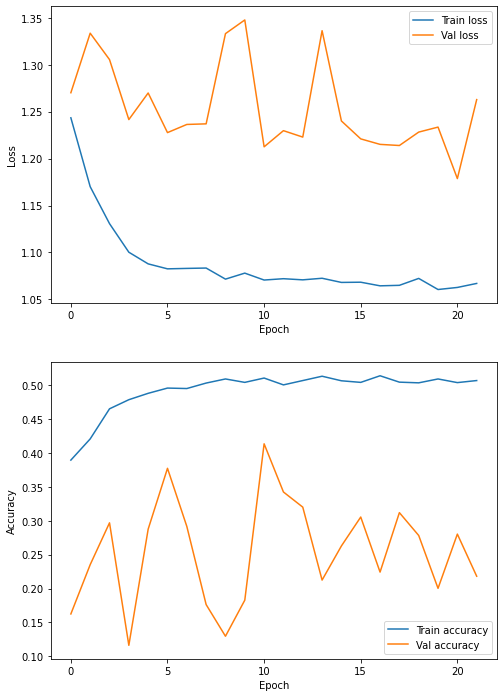

In [104]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [8]:
# save model
cnn_meta.save("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

# model load하는 경우
cnn_meta  = tf.keras.models.load_model("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [105]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'non-ROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [106]:
# X_train을 통한 예측값 비교
y_pred = cnn_meta.predict([X_i_tr,X_m_tr])
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[472   0 126  33]
 [ 98  72  73  55]
 [143   0 885  95]
 [230  12 541 136]]
                    precision    recall  f1-score   support

               HCC       0.50      0.75      0.60       631
cholangiocarcinoma       0.86      0.24      0.38       298
        metastasis       0.54      0.79      0.64      1123
           non-ROI       0.43      0.15      0.22       919

          accuracy                           0.53      2971
         macro avg       0.58      0.48      0.46      2971
      weighted avg       0.53      0.53      0.48      2971



In [107]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn_meta.predict([X_i_te,X_m_te])    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 18   0 127  29]
 [130   0   0   0]
 [ 66   0 144  38]
 [571   4 943 390]]
                    precision    recall  f1-score   support

               HCC       0.02      0.10      0.04       174
cholangiocarcinoma       0.00      0.00      0.00       130
        metastasis       0.12      0.58      0.20       248
           non-ROI       0.85      0.20      0.33      1908

          accuracy                           0.22      2460
         macro avg       0.25      0.22      0.14      2460
      weighted avg       0.68      0.22      0.28      2460



### Dilation rate : 3 No DropOut

In [14]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(3, 3, 3), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(3, 3, 3), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(3, 3, 3), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(3, 3, 3), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta_3 = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64, 64, 5, 1) 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_8 (Conv3D)               (None, 64, 64, 5, 16 144         reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_8 (MaxPooling3D)  (None, 32, 32, 5, 16 0           conv3d_8[0][0]                   
____________________________________________________________________________________________

In [42]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn_meta_3.fit([X_i_tr,X_m_tr], Y_tr_cat, validation_data=([X_i_te,X_m_te], Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
433/433 - 6s - loss: 0.8605 - accuracy: 0.6698 - val_loss: 0.9124 - val_accuracy: 0.6103
Epoch 2/200
433/433 - 6s - loss: 0.8575 - accuracy: 0.6683 - val_loss: 0.7910 - val_accuracy: 0.8305
Epoch 3/200
433/433 - 6s - loss: 0.8536 - accuracy: 0.6696 - val_loss: 0.8080 - val_accuracy: 0.7745
Epoch 4/200
433/433 - 6s - loss: 0.8500 - accuracy: 0.6696 - val_loss: 0.7680 - val_accuracy: 0.7622
Epoch 5/200
433/433 - 6s - loss: 0.8472 - accuracy: 0.6696 - val_loss: 0.7721 - val_accuracy: 0.8305
Epoch 6/200
433/433 - 6s - loss: 0.8454 - accuracy: 0.6682 - val_loss: 0.8318 - val_accuracy: 0.7622


In [43]:
cnn_meta_3.evaluate([X_i_te,X_m_te],Y_te_cat)

82/82 [==============================] - 0s 6ms/step - loss: 0.9124 - accuracy: 0.6103


[0.912372350692749, 0.6102800369262695]

In [44]:
# X_train을 통한 예측값 비교
y_pred = cnn_meta_3.predict([X_i_tr,X_m_tr])
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 392    0    0  936]
 [   0    0    0  796]
 [  16    0    0 2184]
 [ 446    0    0 8192]]
                    precision    recall  f1-score   support

               HCC       0.46      0.30      0.36      1328
cholangiocarcinoma       0.00      0.00      0.00       796
        metastasis       0.00      0.00      0.00      2200
           non-ROI       0.68      0.95      0.79      8638

          accuracy                           0.66     12962
         macro avg       0.28      0.31      0.29     12962
      weighted avg       0.50      0.66      0.56     12962



In [45]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn_meta_3.predict([X_i_te,X_m_te])    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[   0    0    0  141]
 [   0    0    0   30]
 [ 100    0    0  171]
 [ 574    0    0 1591]]
                    precision    recall  f1-score   support

               HCC       0.00      0.00      0.00       141
cholangiocarcinoma       0.00      0.00      0.00        30
        metastasis       0.00      0.00      0.00       271
           non-ROI       0.82      0.73      0.78      2165

          accuracy                           0.61      2607
         macro avg       0.21      0.18      0.19      2607
      weighted avg       0.68      0.61      0.64      2607



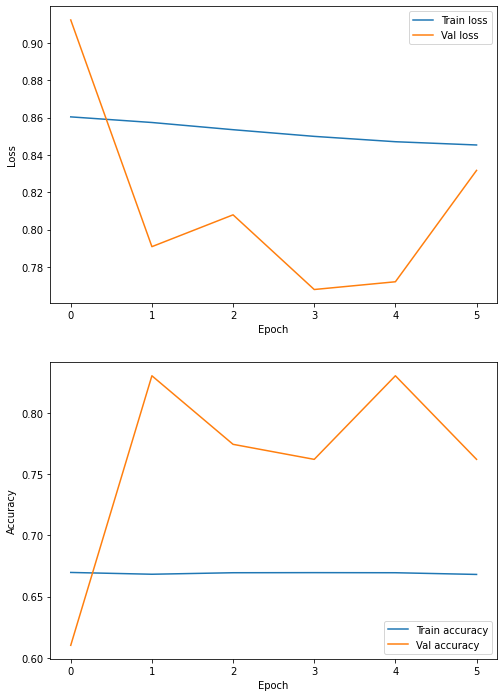

In [46]:
plot_history(cnn_history)